In [2]:
import numpy as np
from sklearn.datasets import load_iris

# Loading the dataset
iris = load_iris()
X_raw = iris['data']
y_raw = iris['target']

# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=len(X_raw)+1, size=3)

# Defining the training data
X_training = X_raw[training_indices]
y_training = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

In [3]:
from sklearn.decomposition import PCA

# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2)
pca.fit(X=X_raw)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [4]:
from modAL.models import ActiveLearner
from modAL.batch import uncertainty_batch_sampling
from sklearn.neighbors import KNeighborsClassifier

# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)

learner = ActiveLearner(
    estimator=knn,
    query_strategy=uncertainty_batch_sampling,
    X_training=X_training, y_training=y_training
)

In [5]:
from modAL.batch import ranked_batch
from modAL.uncertainty import classifier_uncertainty
from sklearn.metrics.pairwise import pairwise_distances

uncertainty = classifier_uncertainty(learner, X_pool)
distance_scores = pairwise_distances(X_pool, X_training, metric='euclidean').min(axis=1)
similarity_scores = 1 / (1 + distance_scores)

alpha = len(X_training)/len(X_raw)

scores = alpha * (1 - similarity_scores) + (1 - alpha) * uncertainty

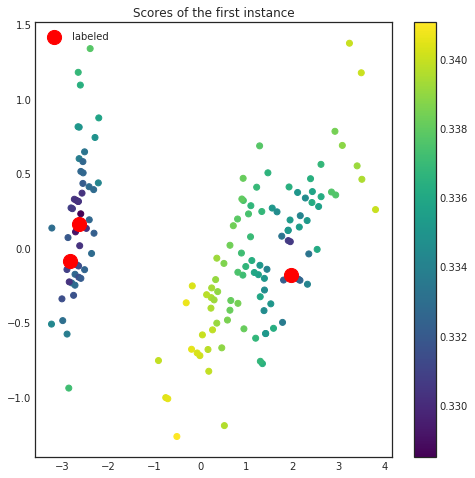

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
transformed_pool = pca.transform(X_pool)
transformed_training = pca.transform(X_training)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_pool[:, 0], transformed_pool[:, 1], c=scores, cmap='viridis')
    plt.colorbar()
    plt.scatter(transformed_training[:, 0], transformed_training[:, 1], c='r', s=200, label='labeled')
    plt.title('Scores of the first instance')
    plt.legend()

In [7]:
query_idx, query_instances = learner.query(X_pool, n_instances=5)

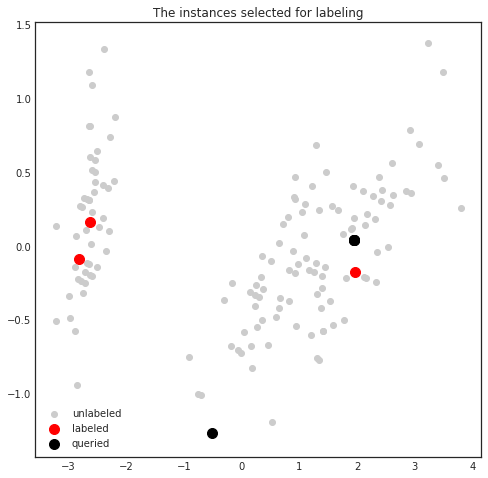

In [8]:
transformed_batch = pca.transform(query_instances)

with plt.style.context('seaborn-white'):
    plt.figure(figsize=(8, 8))
    plt.scatter(transformed_pool[:, 0], transformed_pool[:, 1], c='0.8', label='unlabeled')
    plt.scatter(transformed_training[:, 0], transformed_training[:, 1], c='r', s=100, label='labeled')
    plt.scatter(transformed_batch[:, 0], transformed_batch[:, 1], c='k', s=100, label='queried')
    plt.title('The instances selected for labeling')
    plt.legend()